In [4]:
import numpy as np
from PySDM.physics.constants import si
from PySDM_examples.Luettmer_homogeneous_freezing.commons import run_simulations, hom_pure_droplet_freezing_backend, hom_pure_droplet_freezing_standard_setup
from PySDM_examples.Luettmer_homogeneous_freezing.simulation import Simulation
from PySDM_examples.Luettmer_homogeneous_freezing.settings import Settings
from PySDM_examples.Luettmer_homogeneous_freezing import plot
from importlib import reload
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [13]:
""" General settings """
hom_freezing_types     = [  "KoopMurray2016", "Spichtinger2023" ]
hom_freezing_types_all = [  "KoopMurray2016", "Spichtinger2023", "Koop2000"  ]
number_of_nsd = (1e1, 1e2, 1e3)
vertical_updrafts = np.geomspace(0.2,10,num=9) * si.meter / si.second
number_concentrations = np.geomspace(100, 20000, num=10) / si.cm ** 3

backends = hom_pure_droplet_freezing_backend()
standard = hom_pure_droplet_freezing_standard_setup()

# Do additional simulations and plots for testing
calc_and_show_bulk_plots = False

In [6]:
""" High output step reference simulations """
if calc_and_show_bulk_plots:
    setting_dict = {
                **standard,
                "backend": backends["KoopMurray2016"],
                "hom_freezing": "KoopMurray2016",
                "w_updraft": 2.5,
                "deposition_enable": False,
                "n_output": 1
                }
    KoopMurray2016_reference_high_w_simulation = run_simulations(setting_dict)
    plot.plot_thermodynamics_and_bulk(KoopMurray2016_reference_high_w_simulation, " without vapor deposition")
    show_plot("fig_KM16_high_w_no_dep")

    setting_dict = {
                **standard,
                "backend": backends["Spichtinger2023"],
                "hom_freezing": "Spichtinger2023",
                "w_updraft": 2.5,
                "deposition_enable": False,
                "n_output": 1,
                "dz": 0.1,
                }
    Spichtinger2023_reference_high_w_simulation = run_simulations(setting_dict)
    plot.plot_thermodynamics_and_bulk(Spichtinger2023_reference_high_w_simulation, " without vapor deposition")
    show_plot("fig_SP23_high_w_no_dep")

    setting_dict = {
                **standard,
                "backend": backends["KoopMurray2016"],
                "hom_freezing": "KoopMurray2016",
                "w_updraft": 0.2,
                "deposition_enable": False,
                "n_output": 1,
                "dz": 0.1,
                }
    KoopMurray2016_reference_low_w_simulation = run_simulations(setting_dict)
    plot.plot_thermodynamics_and_bulk(KoopMurray2016_reference_low_w_simulation, " without vapor deposition")
    show_plot("fig_KM16_low_w_no_dep")

In [7]:
""" Simulations for n_sd ensemble without deposition """
nsd_ensemble_no_deposition = {}
nsd_ensemble_no_deposition["ens_variable"] = number_of_nsd
nsd_ensemble_no_deposition["ens_variable_name"] = "n_sd"
nsd_ensemble_no_deposition["hom_freezing_types"] = hom_freezing_types

for hom_freezing_type in hom_freezing_types:
    nsd_ensemble_no_deposition[hom_freezing_type] = []
    for n_sd in number_of_nsd:
        setting_dict = {
            **standard,
            "n_sd": int(n_sd),
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "number_of_ensemble_runs": 5,
            "deposition_enable": False,
            }
        nsd_ensemble_no_deposition[hom_freezing_type].append( run_simulations(setting_dict) )

In [9]:
""" Updraft ensemble simulations without deposition  """
updraft_ensemble_no_deposition = {}
updraft_ensemble_no_deposition["ens_variable"] = vertical_updrafts
updraft_ensemble_no_deposition["ens_variable_name"] = "w_updraft"
updraft_ensemble_no_deposition["hom_freezing_types"] = hom_freezing_types

for hom_freezing_type in hom_freezing_types:
    updraft_ensemble_no_deposition[hom_freezing_type] = []
    for updraft in vertical_updrafts:
        setting_dict = {
            **standard,
            "w_updraft": updraft  * si.meter / si.second,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "deposition_enable": False,
            }
        updraft_ensemble_no_deposition[hom_freezing_type].append( run_simulations(setting_dict) )

In [11]:
""" Simulations for CCN concentration histogram  """
ccn_ensemble_no_deposition = {}
ccn_ensemble_no_deposition["ens_variable"] = number_concentrations
ccn_ensemble_no_deposition["ens_variable_name"] = "n_ccn"
ccn_ensemble_no_deposition["hom_freezing_types"] = hom_freezing_types

for hom_freezing_type in hom_freezing_types:
    ccn_ensemble_no_deposition[hom_freezing_type] = []
    for n_ccn in number_concentrations:
        setting_dict = {
            **standard,
            "n_ccn": n_ccn,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "deposition_enable": False,
        }
        ccn_ensemble_no_deposition[hom_freezing_type].append(run_simulations(setting_dict))

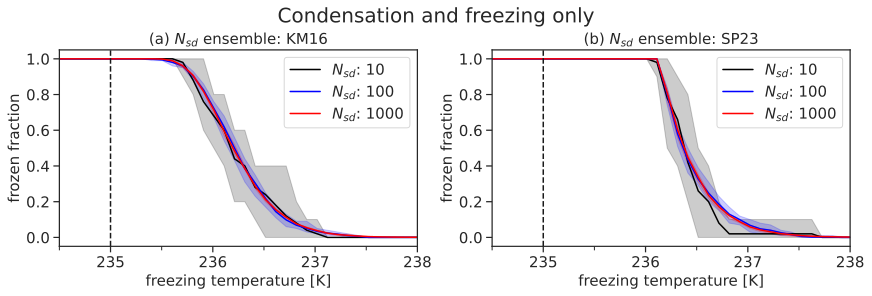

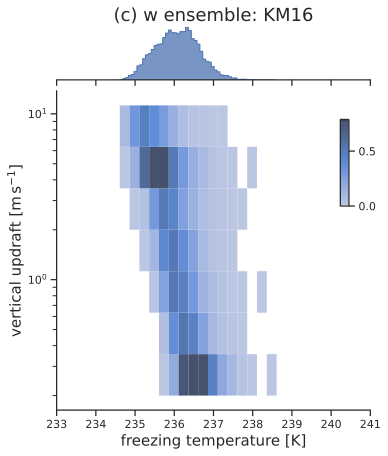

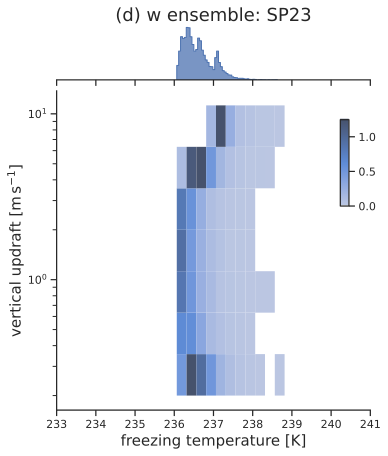

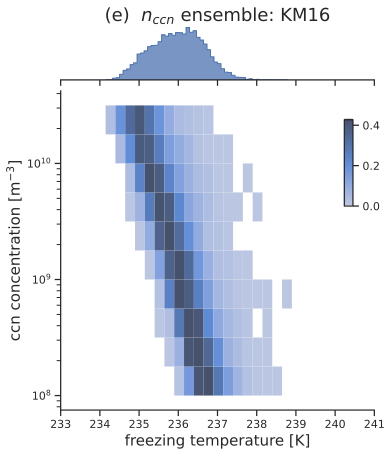

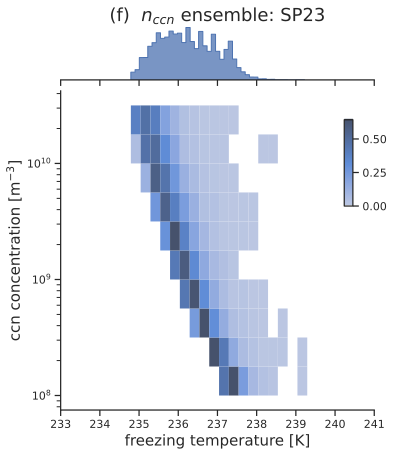

In [47]:
""" Plot Figure 2 """
reload(plot)
fig, axs = pyplot.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig.suptitle("Condensation and freezing only",fontsize=20)

axs = axs.ravel()

axs[0] = plot.plot_freezing_temperatures_histogram_allinone(axs[0], nsd_ensemble_no_deposition["KoopMurray2016"], title = r"(a) $N_{sd}$ ensemble: KM16")
axs[1] = plot.plot_freezing_temperatures_histogram_allinone(axs[1], nsd_ensemble_no_deposition["Spichtinger2023"], title = r"(b) $N_{sd}$ ensemble: SP23")
show_plot("fig2_ab")

plot.plot_freezing_temperatures_2d_histogram_seaborn(updraft_ensemble_no_deposition, "KoopMurray2016", title = "(c) w ensemble: KM16")
show_plot("fig2_c")

plot.plot_freezing_temperatures_2d_histogram_seaborn(updraft_ensemble_no_deposition, "Spichtinger2023", title = "(d) w ensemble: SP23")
show_plot("fig2_d")

plot.plot_freezing_temperatures_2d_histogram_seaborn(ccn_ensemble_no_deposition, "KoopMurray2016", title = r"(e)  $n_{ccn}$ ensemble: KM16")
show_plot("fig2_e")

plot.plot_freezing_temperatures_2d_histogram_seaborn(ccn_ensemble_no_deposition, "Spichtinger2023", title = r"(f)  $n_{ccn}$ ensemble: SP23")
show_plot("fig2_f")